In [1]:
import tensorflow as tf

using_gpu_index = 0 # 使用的 GPU 号码
gpu_list = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(
        gpu_list[using_gpu_index],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 4)]
    )

2023-10-16 17:53:00.570322: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-16 17:53:00.574557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-16 17:53:00.574659: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
import cirq
import models.quantum_genotypes as genotypes

from models.quantum_models import generate_model_policy
from functools import reduce
env_name = "Acrobot-v1"

genotype = genotypes.ORI_TYPE_AB

n_qubits = 6 # Dimension of the state vectors in CartPole
# n_layers = 5 # Number of layers in the PQC
n_actions = 3 # Number of actions in CartPole

qubits = cirq.GridQubit.rect(1, n_qubits)
observables = [cirq.Z(qubits[0]), cirq.Z(qubits[1]), cirq.Z(qubits[2]), cirq.Z(qubits[3]), cirq.Z(qubits[4]), cirq.Z(qubits[5])] # Z_0*Z_1*Z_2*Z_3


# generate_model_policy(qubits, genotype, n_actions, beta, observables, env):
model = generate_model_policy(qubits, genotype, n_actions, 1., observables, env_name, using_H=True)

2023-10-16 17:53:07.630952: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 17:53:07.631732: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-16 17:53:07.631853: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-16 17:53:07.631913: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Acrobot-v1


In [3]:
from models.value_net import ValueNet

In [4]:
from IPython.core.display import HTML
from models.quantum_models import generate_circuit

circuit, params, inputs = generate_circuit(qubits, genotype, using_H=True)
display(HTML(f"<pre>{circuit}</pre>"))

In [5]:
from tensorflow.keras.optimizers import Adam
import gym
env_name = "Acrobot-v1"
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
# hidden_dim = 64

# device = torch.device("cpu")

actor = model

critic = ValueNet()  # 价值网络
# 广义优势估计（Generalized Advantage Estimation，GAE）
# gamma 是GAE的超参数
gamma = 0.98

# lmbda 也用来计算广义优势估
lmbda = 0.95

epochs = 10  # 一条序列的数据用来训练轮数 4
# epochs = 4  # 一条序列的数据用来训练轮数 4
eps = 0.2  # 裁剪超参数
# actor_lr = 1e-3
# critic_lr = 1e-2  # 结合 量子电路后 这个变得重要了起来
# critic_lr = 1e-1  # 结合 量子电路后 这个变得重要了起来
critic_lr = 2.5e-4 #

# actor_optimizer = Adam(learning_rate=actor_lr)

optimizer_in = Adam(learning_rate=0.1, amsgrad=False, epsilon=1e-5)
optimizer_var = Adam(learning_rate=0.01, amsgrad=False, epsilon=1e-5)
optimizer_out = Adam(learning_rate=0.1, amsgrad=False, epsilon=1e-5)

# Assign the model parameters to each optimizer
w_in, w_var, w_out = 1, 0, 2

# critic_optimizer = Adam(learning_rate=critic_lr)
critic_optimizer = Adam(learning_rate=critic_lr, amsgrad=False, epsilon=1e-5) 

In [6]:
from misc.utils import train

In [7]:
import numpy as np

state_bounds = np.array([1., 1., 1., 1., 12.567 , 28.274])
state_ub = state_bounds
state_lb = -1 * state_bounds

In [ ]:
return_list = train(env_name, actor, critic, gamma, lmbda, eps, epochs,
          optimizer_in, optimizer_var, optimizer_out, critic_optimizer, -150.,
          critic_normalized=True, state_ub=state_ub, state_lb=state_lb, num_episodes=5000)

In [9]:
import pandas as pd

# 创建一个DataFrame对象
df = pd.DataFrame({'return_list': return_list})

# 将DataFrame保存到CSV文件
df.to_csv('../../../../results/example/ppo/ppo_quafu/all_state_normalize/return_list_AB', index=False)  # 可以指定文件名和是否包括行索引
actor.save_weights('../../../../weights/example/ppo/ppo_quafu/all_state_normalize/weights_AB_ACTOR_amsgrad.h5')
critic.save_weights('../../../../weights/example/ppo/ppo_quafu/all_state_normalize/weights_AB_CRITIC_amsgrad.h5')

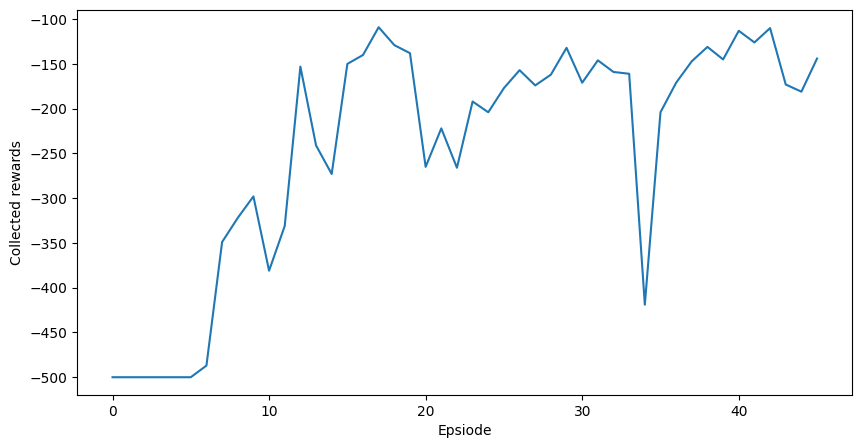

In [10]:
from matplotlib import pyplot as plt

# validate
plt.figure(figsize=(10,5))
plt.plot(return_list)
plt.xlabel('Epsiode')
plt.ylabel('Collected rewards')
plt.show()